## Guidovia

#### Misc

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
valore_g_padova = 9.806

In [3]:
incertezza_alpha = 1/144

#### Import

In [4]:
df = pd.read_csv('MisureGuidovia.txt', sep='\t')

In [5]:
dists = [str(x) for x in range(10,100,10)]
np_arr = np.stack(np.split(df[dists].to_numpy().T, [10,20,30], 1), 0)

#### Xarray

In [6]:
ds1 = xr.Dataset(
    data_vars = dict(
        alpha = ('set', [.25, .5, .75, .75], dict(unit='degrees')),
        x1 = (['d'], np.arange(.4, 1.3, .1), dict(unit='m')),
        x2 = (['d'], np.arange(.5, 1.4, .1), dict(unit='m')),
        t = (['set', 'd', 'n'], np_arr / 10000, dict(unit='seconds'))
    ),
    coords = dict(
        set = ('set', ['15', '30', '45', '45c']),
        d = ('d', range(10,100,10)),
        n = ('n', range(10))
    ),
    attrs = dict()
)

ds1

<xarray.Dataset>
Dimensions:  (set: 4, d: 9, n: 10)
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90
  * n        (n) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    alpha    (set) float64 0.25 0.5 0.75 0.75
    x1       (d) float64 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2
    x2       (d) float64 0.5 0.6 0.7 0.8 0.9 1.0 1.1 1.2 1.3
    t        (set, d, n) float64 0.6545 0.6589 0.6593 ... 2.336 2.338 2.344

In [7]:
da_temp = ds1.t

ds2 = xr.merge([
    da_temp.mean(dim='n').rename('t'),
    da_temp.std(dim='n').rename('t_std'),
    da_temp.std(dim='n').rename('t_sem') / np.sqrt(da_temp.n.size),
    ], compat='override')

ds2

<xarray.Dataset>
Dimensions:  (set: 4, d: 9)
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90
Data variables:
    t        (set, d) float64 0.659 1.228 1.735 2.204 ... 1.73 1.945 2.147 2.34
    t_std    (set, d) float64 0.003556 0.00795 0.005102 ... 0.002552 0.003813
    t_sem    (set, d) float64 0.001124 0.002514 0.001613 ... 0.0008071 0.001206

In [8]:
# tempo intervallo
da_temp = ds2.t

da_ti = xr.apply_ufunc(
    lambda arr: np.convolve(arr, [1,-1], mode='same'),
    da_temp, 
    input_core_dims=[['d']], 
    output_core_dims=[['d']], 
    vectorize=True
).rename('ti')

da_ti

<xarray.DataArray 'ti' (set: 4, d: 9)>
array([[0.65901, 0.56858, 0.50739, 0.46937, 0.42678, 0.3946 , 0.378  ,
        0.36252, 0.34798],
       [0.46281, 0.39918, 0.3566 , 0.32518, 0.29788, 0.27675, 0.26552,
        0.25757, 0.24197],
       [0.37905, 0.32468, 0.29028, 0.26444, 0.24212, 0.23647, 0.21001,
        0.2048 , 0.19135],
       [0.37854, 0.32562, 0.2882 , 0.26656, 0.2426 , 0.22845, 0.21545,
        0.20185, 0.19223]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90

In [9]:
da_t1 = ds2.t.roll(shifts=dict(d=1))
da_t1 = da_t1.where(da_t1.d > 10).fillna(0).rename('t1')

da_t1

<xarray.DataArray 't1' (set: 4, d: 9)>
array([[0.     , 0.65901, 1.22759, 1.73498, 2.20435, 2.63113, 3.02573,
        3.40373, 3.76625],
       [0.     , 0.46281, 0.86199, 1.21859, 1.54377, 1.84165, 2.1184 ,
        2.38392, 2.64149],
       [0.     , 0.37905, 0.70373, 0.99401, 1.25845, 1.50057, 1.73704,
        1.94705, 2.15185],
       [0.     , 0.37854, 0.70416, 0.99236, 1.25892, 1.50152, 1.72997,
        1.94542, 2.14727]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90

In [10]:
da_t1_sig = ds2.t_sem.roll(shifts=dict(d=1))
da_t1_sig = da_t1_sig.where(da_t1_sig.d > 10).fillna(0).rename('t1_sig')

da_t1_sig

<xarray.DataArray 't1_sig' (set: 4, d: 9)>
array([[0.        , 0.0011245 , 0.00251406, 0.00161349, 0.00334426,
        0.00263333, 0.00424888, 0.00384669, 0.00241401],
       [0.        , 0.00055614, 0.00106174, 0.00115199, 0.00072042,
        0.00188654, 0.00118093, 0.00254891, 0.00143509],
       [0.        , 0.00018069, 0.00029464, 0.0006523 , 0.00078769,
        0.00125881, 0.00118188, 0.00134427, 0.00167214],
       [0.        , 0.00015505, 0.00031407, 0.0001991 , 0.00026601,
        0.00024364, 0.00041882, 0.00064169, 0.0008071 ]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90

In [11]:
da_t2 = ds2.t.copy().rename('t2')

da_t2

<xarray.DataArray 't2' (set: 4, d: 9)>
array([[0.65901, 1.22759, 1.73498, 2.20435, 2.63113, 3.02573, 3.40373,
        3.76625, 4.11423],
       [0.46281, 0.86199, 1.21859, 1.54377, 1.84165, 2.1184 , 2.38392,
        2.64149, 2.88346],
       [0.37905, 0.70373, 0.99401, 1.25845, 1.50057, 1.73704, 1.94705,
        2.15185, 2.3432 ],
       [0.37854, 0.70416, 0.99236, 1.25892, 1.50152, 1.72997, 1.94542,
        2.14727, 2.3395 ]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90

In [12]:
da_t2_sig = ds2.t_sem.copy().rename('t2_sig')

da_t2_sig

<xarray.DataArray 't2_sig' (set: 4, d: 9)>
array([[0.0011245 , 0.00251406, 0.00161349, 0.00334426, 0.00263333,
        0.00424888, 0.00384669, 0.00241401, 0.0058149 ],
       [0.00055614, 0.00106174, 0.00115199, 0.00072042, 0.00188654,
        0.00118093, 0.00254891, 0.00143509, 0.00246098],
       [0.00018069, 0.00029464, 0.0006523 , 0.00078769, 0.00125881,
        0.00118188, 0.00134427, 0.00167214, 0.0006876 ],
       [0.00015505, 0.00031407, 0.0001991 , 0.00026601, 0.00024364,
        0.00041882, 0.00064169, 0.0008071 , 0.00120565]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90

##### Velocità

In [13]:
da_vi = (.1 / da_ti).rename('vi')

da_vi

<xarray.DataArray 'vi' (set: 4, d: 9)>
array([[0.15174277, 0.17587675, 0.19708705, 0.21305154, 0.23431276,
        0.25342119, 0.26455026, 0.27584685, 0.28737284],
       [0.21607139, 0.25051355, 0.28042625, 0.30752199, 0.33570565,
        0.36133695, 0.37661946, 0.38824397, 0.41327437],
       [0.26381744, 0.30799556, 0.34449497, 0.37815762, 0.41301834,
        0.42288662, 0.4761678 , 0.48828125, 0.52260256],
       [0.26417287, 0.30710644, 0.34698126, 0.37515006, 0.41220115,
        0.43773255, 0.46414481, 0.49541739, 0.52021016]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90

In [14]:
sig_x = .0005
A = ds1.x2 - ds1.x1
B = 1 / (da_t2 - da_t1)

da_vi_sig = ((B*sig_x)**2 + (B*sig_x)**2 + (da_t1_sig*A*B**2)**2 + (da_t2_sig*A*B**2)**2) ** .5
da_vi_sig = da_vi_sig.rename('vi_sig')

da_vi_sig

<xarray.DataArray 'vi_sig' (set: 4, d: 9)>
array([[0.00110378, 0.00150744, 0.00181345, 0.00226058, 0.00286471,
        0.00367657, 0.00442604, 0.00396812, 0.00558246],
       [0.00154976, 0.00192448, 0.00233447, 0.00252577, 0.00328853,
        0.00386946, 0.00479263, 0.00519398, 0.00567582],
       [0.00186971, 0.0022024 , 0.0025798 , 0.0030478 , 0.00386597,
        0.00429845, 0.0052733 , 0.00617143, 0.00616752],
       [0.00187112, 0.00219655, 0.00249404, 0.00269361, 0.00297845,
        0.00323148, 0.00367377, 0.00432163, 0.00538023]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90

##### Fit Velocità/Tempo

In [15]:
def interp_fit(X,Y):
    N = X.size
    DELTA = N * (X ** 2).sum() - (X.sum()) ** 2
    a = ((X**2).sum()*(Y.sum()) - (X.sum())*(X*Y).sum()) / DELTA # q
    b = (N*(X*Y).sum() - (X.sum())*(Y.sum())) / DELTA            # m
    #
    SIGy = ((((a+b*X)-Y)**2).sum()/ (N-2)) ** .5
    SIGa = SIGy * ((X**2).sum() / DELTA) ** .5
    SIGb = SIGy * (N / DELTA) ** .5
    #
    return np.array([a, b, SIGb])
    

In [16]:
da_interp = xr.apply_ufunc(
    interp_fit, 
    ds2.t,
    da_vi,
    exclude_dims=set('d'),
    input_core_dims=[['d'], ['d']],
    output_core_dims=[['deg']],
    vectorize=True
).assign_coords(deg=['q', 'm', 'm_sig']).rename('fit')

da_interp


<xarray.DataArray 'fit' (set: 4, deg: 3)>
array([[0.12725381, 0.03988131, 0.00090946],
       [0.18179105, 0.08107218, 0.00206702],
       [0.21538966, 0.12899897, 0.00417019],
       [0.21547612, 0.12954883, 0.00136117]])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * deg      (deg) <U5 'q' 'm' 'm_sig'

##### Stima g

In [17]:
da_g = (da_interp.sel(deg='m') / np.sin(ds1.alpha * 3.1415/180)).rename('g')

da_g

<xarray.DataArray 'g' (set: 4)>
array([9.14042112, 9.29057893, 9.85536771, 9.89737577])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
    deg      <U5 'm'

In [18]:
SIN = np.sin(ds1.alpha * 3.1415 / 180)
COS = np.cos(ds1.alpha * 3.1415 / 180)

da_g_sig = ( (da_interp.sel(deg='m_sig') / SIN)**2 + (da_interp.sel(deg='m') * incertezza_alpha*(3.1415/180) * COS / SIN**2).to_numpy()**2 ) ** .5
da_g_sig = da_g_sig.rename('g_sig')

da_g_sig

<xarray.DataArray 'g_sig' (set: 4)>
array([0.32849895, 0.26973694, 0.331407  , 0.13860598])
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
    deg      <U5 'm_sig'

##### Finale

In [19]:
ds3 = xr.merge([da_t1, da_t2, da_ti, da_vi, da_vi_sig, da_interp, da_g, da_g_sig])

ds3

<xarray.Dataset>
Dimensions:  (set: 4, d: 9, deg: 3)
Coordinates:
  * set      (set) <U3 '15' '30' '45' '45c'
  * d        (d) int64 10 20 30 40 50 60 70 80 90
  * deg      (deg) <U5 'q' 'm' 'm_sig'
Data variables:
    t1       (set, d) float64 0.0 0.659 1.228 1.735 ... 1.502 1.73 1.945 2.147
    t2       (set, d) float64 0.659 1.228 1.735 2.204 ... 1.73 1.945 2.147 2.34
    ti       (set, d) float64 0.659 0.5686 0.5074 ... 0.2154 0.2018 0.1922
    vi       (set, d) float64 0.1517 0.1759 0.1971 ... 0.4641 0.4954 0.5202
    vi_sig   (set, d) float64 0.001104 0.001507 0.001813 ... 0.004322 0.00538
    fit      (set, deg) float64 0.1273 0.03988 0.0009095 ... 0.1295 0.001361
    g        (set) float64 9.14 9.291 9.855 9.897
    g_sig    (set) float64 0.3285 0.2697 0.3314 0.1386

#### Export to Excel

In [ ]:
ds2.to_dataframe().to_excel('dump_t.xlsx')

In [ ]:
ds3[['t1', 't2', 'ti']].to_dataframe().to_excel('dump_ts.xlsx')

In [ ]:
ds3[['vi', 'vi_sig']].to_dataframe().to_excel('dump_vi.xlsx')

In [28]:
ds3[['fit']].to_dataframe().to_excel('dump_fit.xlsx')

In [30]:
ds3[['g', 'g_sig']].to_dataframe().to_excel('dump_g.xlsx')

#### Plot

In [23]:
graph_base_name = '../grafici/graph_'

In [24]:
style = ['white', 'dark', 'whitegrid', 'darkgrid', 'ticks'][2]
sns.set_style(style)

In [25]:
palette = sns.husl_palette(18)
print(' ', [' '+str(x) for x in range(6)],' ', [' '+str(x+6) for x in range(6)], ['_'+str(x+12) for x in range(6)])
palette

  [' 0', ' 1', ' 2', ' 3', ' 4', ' 5']   [' 6', ' 7', ' 8', ' 9', ' 10', ' 11'] ['_12', '_13', '_14', '_15', '_16', '_17']


[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9707505829046977, 0.4626541987597626, 0.26486329418330007),
 (0.8369430560927636, 0.5495828952802333, 0.1952683223448124),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6430915736746491, 0.6271955086583126, 0.19381135329796756),
 (0.5310702086647983, 0.6569113639885688, 0.1931838276161326),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.1998437102815942, 0.6927711055021983, 0.4485948481767363),
 (0.20582072623426667, 0.6842209016721069, 0.5675558225732941),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.2151139535594307, 0.6700707833028816, 0.7112365203426209),
 (0.22126158707091403, 0.6600977737826563, 0.7915486637100363),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5392573577708815, 0.5821140171749066, 0.9584212824085171),
 (0.731751635642941, 0.5128186367840487, 0.9581005178234921),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9614880299080136, 0.3909885385134758, 0.8298287106954371),
 (0.9648889414626248, 0.41896694790705413, 0.692031255809005)]

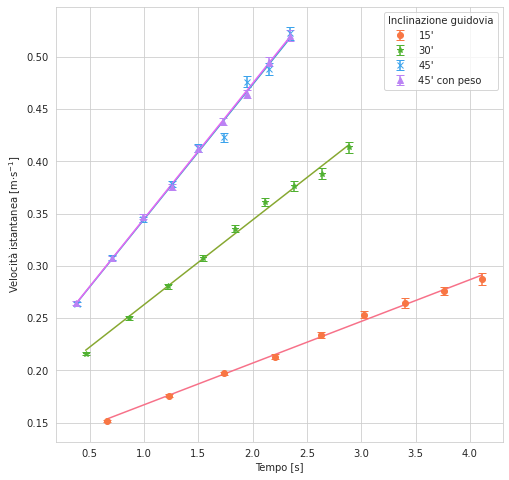

In [26]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,8))

syms = iter(['o', '*', 'x', '^'])
clrs1 = iter([palette[x] for x in [1, 6, 12, 14] ])
clrs2 = iter([palette[x] for x in [0, 5, 11, 15] ])
lbls = iter(["15'", "30'", "45'", "45' con peso   "])

def plot4(ds):
    X = ds.t2
    Y = ds.vi
    Yerr = ds.vi_sig

    m = ds.fit.sel(deg='m').item()
    q = ds.fit.sel(deg='q').item()

    x = [X.min(), X.max()]
    y = [m*x+q for x in x]
    plt.plot(x, y, '-', color=next(clrs2))

    # plt.plot(X, Y, 'o', label=ds.set.item())
    plt.errorbar(X, Y, yerr=Yerr, fmt=next(syms), capsize=4, label=next(lbls), color=next(clrs1))


for set in ds3.set.values:
    plot4(ds3.sel(set=set))

plt.xlabel('Tempo [s]')
plt.ylabel('Velocità istantanea [m$\cdot$s$^{-1}$]')

plt.legend(title='Inclinazione guidovia')

plt.savefig(graph_base_name+'graph_velocita', dpi=200)

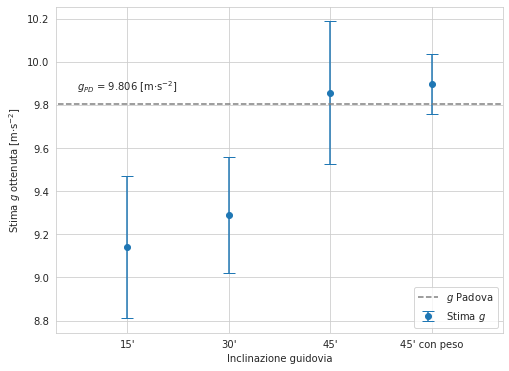

In [27]:
def plot7(ds):
    X = [0, 1, 2, 3]
    Xlab = ["15'", "30'", "45'", "45' con peso"]
    arr = ds.g.to_numpy()

    sns.set_style('whitegrid', {"grid.color": ".8"})
    plt.figure(figsize=(8,6))

    # plt.plot(X, arr, 'o', label='Stima $g$')
    plt.errorbar(X, arr, ds.g_sig, fmt='o', capsize=6, label='Stima $g$')#, color=palette[12])

    lX = [-0.5, 3.5]
    lX = [-0.68, 3.7]
    lY = [valore_g_padova, valore_g_padova]

    plt.plot(lX, lY, '--', color='grey', label='$g$ Padova')

    plt.xlim(-0.7, 3.7)
    # plt.ylim(arr.min() -.2, arr.max()+.2 )
    plt.xticks(X, Xlab)

    plt.xlabel('Inclinazione guidovia')
    plt.ylabel('Stima $g$ ottenuta [m$\cdot$s$^{-2}$]')

    # plt.gca().tick_params(bottom=True, left=True)

    plt.legend(loc='lower right')

    plt.gca().annotate(
        '$g_{PD}$ = '+str(valore_g_padova)+' [m$\cdot$s$^{-2}$]', xy=(-0.1+.3, valore_g_padova), 
        xycoords='data', textcoords='data', 
        xytext=(-0.1+.1, valore_g_padova + .15-.09), horizontalalignment='center')
        #arrowprops=dict(facecolor='black', width=0.3, headwidth=5, headlength=5, shrink=0.15))    
    
    plt.savefig(graph_base_name+'graph_stime_g', dpi=200)

plot7(ds3)